In [82]:
import pandas as pd
import numpy as np
import os
import json
import re
from tqdm import tqdm # to show progress bar in for loops
import ast
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, DateFormatter

%matplotlib inline

# to increase display width of dataframes in jupyter notebook
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [2]:
root = "movie_dataset/"

In [3]:
os.listdir(root)

['movies_metadata.csv',
 'keywords.csv',
 'ratings.csv',
 'credits.csv',
 'links.csv',
 'links_small.csv',
 'ratings_small.csv']

## credits.csv

In [4]:
credits = pd.read_csv(root+'credits.csv')

In [5]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [6]:
credits.shape
credits.columns

Index(['cast', 'crew', 'id'], dtype='object')

In [7]:
def run_csv(df, no_rows=2):
    credits_json = []
    for x in tqdm(range(2)):
        tmp_dict = {}
        for col in df.columns:
            #print(y)
            if col  == 'id':
                tmp_dict['id'] = df[col][x]
            else:
                tmp_dict[col] = ast.literal_eval(df[col][x])

        credits_json.append(tmp_dict)
    return credits_json

def json_to_file(obj, fp='test.json', indent=3):
    with open('test.json', 'w') as f:
        json.dump(obj, f, default=str, indent=indent)
    print('file saved',fp)

In [8]:
lol = run_csv(credits)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 302.19it/s]


In [9]:
json_to_file(lol)

file saved test.json


## movies_metadata.csv

In [10]:
movies_meta = pd.read_csv(root+'movies_metadata.csv', low_memory=False)

In [11]:
movies_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [12]:
movies_meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,FALSE,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",30-10-1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,FALSE,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",15-12-1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,FALSE,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",22-12-1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,FALSE,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",22-12-1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,FALSE,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",10-02-1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


#### From the above inspection, we can see that we don't have any use for the following columns: `video`, `status`, `poster_path`; Hence we shall be dropping them from the dataframe

In [13]:
movies_meta.drop(['video', 'status', 'poster_path'], axis=1, inplace=True)

#### cleaning `id`

In [14]:
def clean_id(x):
    try:
        return int(x)
    except:
        return None

In [15]:
movies_meta.id = movies_meta.id.apply(clean_id)

In [16]:
movies_meta = movies_meta[~movies_meta['id'].isna()]

In [17]:
def clean_genres(x, key, fill_na):
    '''
    To show only the clear genre names as a list
    '''
    if fill_na:
        if pd.isna(x) or x=='[]' or x=='':
            return fill_na
    try:
        x = x.replace('None','\"\"')
        x = ast.literal_eval(x)
        if type(x) == list:
            return [gen[key] for gen in x]
        else:
            return x[key]
    except:
        return x

In [18]:
cols_json_clean = [("genres", "name", ["UNK"]),
                   ("belongs_to_collection","name","Independent Movie"),
                   ("spoken_languages", 'iso_639_1', ["UNK"]), ("production_companies", "name", ["UNK"]), ("production_countries", "name", ["UNK"])]

for c in cols_json_clean:
    movies_meta[c[0]] = movies_meta[c[0]].apply(clean_genres, args=(c[1],c[2],))

In [19]:
movies_meta.tail()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
45461,FALSE,Independent Movie,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050.0,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,[UNK],[Iran],NaN,0.0,90.0,[fa],Rising and falling between a man and woman,Subdue,4.0,1.0
45462,FALSE,Independent Movie,0,[Drama],NaN,111109.0,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,[Sine Olivia],[Philippines],17-11-2011,0.0,360.0,[tl],NaN,Century of Birthing,9.0,3.0
45463,FALSE,Independent Movie,0,"[Action, Drama, Thriller]",NaN,67758.0,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,[American World Pictures],[United States of America],01-08-2003,0.0,90.0,[en],A deadly game of wits.,Betrayal,3.8,6.0
45464,FALSE,Independent Movie,0,[UNK],NaN,227506.0,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,[Yermoliev],[Russia],21-10-1917,0.0,87.0,[UNK],NaN,Satan Triumphant,0.0,0.0
45465,FALSE,Independent Movie,0,[UNK],NaN,461257.0,tt6980792,en,Queerama,50 years after decriminalisation of homosexual...,0.163015,[UNK],[United Kingdom],09-06-2017,0.0,75.0,[en],NaN,Queerama,0.0,0.0


#### cleaning `budget`

In [20]:
movies_meta.budget = movies_meta.budget.astype(int)

In [21]:
# setting the budget of the movies with value `0` to `-1` (to signify that data is missing)
movies_meta.budget = movies_meta.budget.apply(lambda x: -1 if (x==0) else x)

#### understanding `popularity`

In [22]:
movies_meta.popularity = movies_meta.popularity.astype(float)

In [23]:
movies_meta.popularity = minmax_scale(movies_meta.popularity) # scaling the value between 0 & 1

Text(0.5, 1.0, 'Top 10 popular movies')

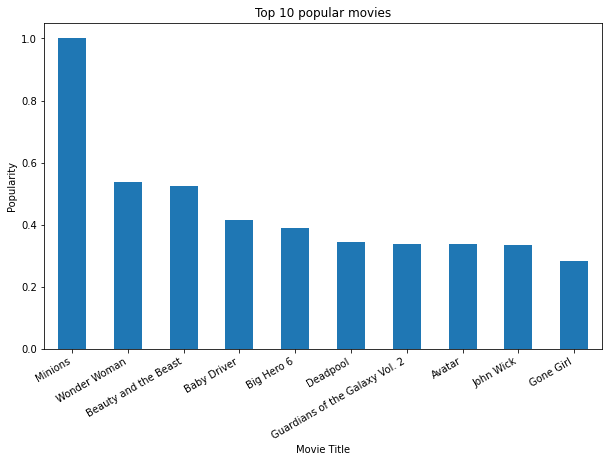

In [24]:
temp = movies_meta[movies_meta.popularity>0.2].sort_values(by='popularity', ascending=False)[:10]
temp.index = temp['title']
temp['popularity'].plot(kind='bar', figsize=(10,6))

#temp.budget.plot(kind='bar')
plt.xticks(rotation=30, horizontalalignment="right")
plt.ylabel('Popularity')
plt.xlabel('Movie Title')
plt.title('Top 10 popular movies')

#### cleaning `homepage` : filling null values with `UNK` for consistency

In [37]:
movies_meta['homepage'].fillna('UNK',inplace=True)

### setting `release_date` as datetime column to perform time based analysis on the data

In [40]:
movies_meta['release_date'] = pd.to_datetime(movies_meta['release_date'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 0, 'Year')

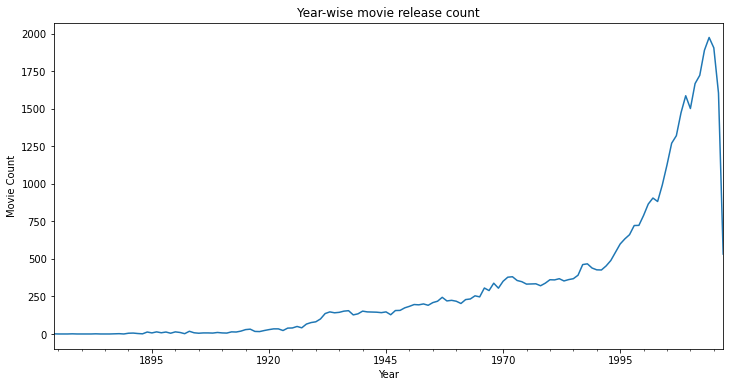

In [94]:
# year-wise movie release frequency
plt.figure(figsize=(12,6))

ax = movies_meta.groupby(pd.Grouper(key='release_date', freq='Y')).count()['id'][:-3].plot()
plt.title("Year-wise movie release count")
plt.ylabel('Movie Count')
plt.xlabel('Year')

#### Normalizing movie ratings by no. of votes [weighted_rating](https://stackoverflow.com/questions/8542391/how-to-normalize-reviews-based-on-score)

In [109]:
movies_meta['vote_average'][movies_meta['vote_average']!=0].mean()

6.014876831048937

In [113]:
def weighted_rating(x):
    min_vote_thresh = 3000
    mean_rating_for_all_movies = 6.015
    min_vote_thresh_movie_rating_sum = x[1] + min_vote_thresh
    
    if x[0]==0 or x[1]==0:
        return -1
    return round((((x[1] * x[0]) / min_vote_thresh_movie_rating_sum) \
      + (min_vote_thresh / min_vote_thresh_movie_rating_sum)) \
    * mean_rating_for_all_movies, 3) 

In [115]:
movies_meta['ratings_normalized'] = movies_meta[['vote_average', 'vote_count']].apply(weighted_rating, axis=1)

In [116]:
movies_meta

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,ratings_normalized
0,FALSE,Toy Story Collection,30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",0.040087,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[en],NaN,Toy Story,7.7,5415.0,31.948
1,FALSE,Independent Movie,65000000,"[Adventure, Fantasy, Family]",UNK,8844.0,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,0.031079,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[en, fr]",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,21.835
2,FALSE,Grumpy Old Men Collection,-1,"[Romance, Comedy]",UNK,15602.0,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,0.021394,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[en],Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,6.999
3,FALSE,Independent Movie,16000000,"[Comedy, Drama, Romance]",UNK,31357.0,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",0.007049,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,[en],Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,6.359
4,FALSE,Father of the Bride Collection,-1,[Comedy],UNK,11862.0,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,0.015320,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-10-02,76578911.0,106.0,[en],Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,7.556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,FALSE,Independent Movie,-1,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050.0,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.000132,[UNK],[Iran],NaT,0.0,90.0,[fa],Rising and falling between a man and woman,Subdue,4.0,1.0,6.021
45462,FALSE,Independent Movie,-1,[Drama],UNK,111109.0,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.000326,[Sine Olivia],[Philippines],2011-11-17,0.0,360.0,[tl],NaN,Century of Birthing,9.0,3.0,6.063
45463,FALSE,Independent Movie,-1,"[Action, Drama, Thriller]",UNK,67758.0,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.001649,[American World Pictures],[United States of America],2003-01-08,0.0,90.0,[en],A deadly game of wits.,Betrayal,3.8,6.0,6.049
45464,FALSE,Independent Movie,-1,[UNK],UNK,227506.0,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.000006,[Yermoliev],[Russia],1917-10-21,0.0,87.0,[UNK],NaN,Satan Triumphant,0.0,0.0,-1.000


In [117]:
movies_meta.to_json('movies_data.json')

### links.csv

In [25]:
links_df = pd.read_csv(os.path.join(root, 'links.csv'))

In [18]:
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
45838,176269,6209470,439050.0
45839,176271,2028550,111109.0
45840,176273,303758,67758.0
45841,176275,8536,227506.0
